# Importing libraries and Preparing DATA

In [ ]:
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
from torch import nn,optim
torch.manual_seed(1997)

In [ ]:
batch_size=128
noise_dim=128
img_dims=(32,32)

In [ ]:
MNIST=torchvision.datasets.MNIST(root='./',download=True,transform=transforms.Compose([transforms.Resize(img_dims),transforms.ToTensor(),transforms.Normalize(0.5,0.5)]))

In [ ]:
dataloader=DataLoader(MNIST,batch_size,True)

In [ ]:
def display_MNIST_image(image):
  plt.figure()
  plt.imshow( (((image*0.5)+0.5)*255).view(img_dims[0],img_dims[1]),cmap='gray' )

# Creating and Training classical GAN

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.Layer_1=nn.Sequential(nn.Linear(noise_dim,256),nn.LeakyReLU(0.2,inplace=True))
    self.Layer_2=nn.Sequential(nn.Linear(256,512),nn.LeakyReLU(0.2,inplace=True))
    self.Layer_3=nn.Sequential(nn.Linear(512,1024),nn.LeakyReLU(0.2,inplace=True))
    self.Final_layer=nn.Sequential(nn.Linear(1024,img_dims[0]*img_dims[1]),nn.Tanh())
  def forward(self,x):
    out=self.Final_layer(self.Layer_3(self.Layer_2(self.Layer_1(x))))
    out=out.view(-1,img_dims[0],img_dims[1])
    return out



In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.Layer_1=nn.Sequential(*[nn.Linear(img_dims[0]*img_dims[1],512),nn.LeakyReLU(0.2,inplace=True)])
    self.Layer_2=nn.Sequential(*[nn.Linear(512,256),nn.LeakyReLU(0.2,inplace=True)])
    self.Layer_3=nn.Sequential(*[nn.Linear(256,128),nn.LeakyReLU(0.2,inplace=True)])
    self.Final_layer=nn.Sequential(*[nn.Linear(128,1),nn.Sigmoid()])
  def forward(self,x):
    x=x.view(-1,img_dims[0]*img_dims[1])
    out=self.Final_layer(self.Layer_3(self.Layer_2(self.Layer_1(x))))
    return out

In [ ]:
generator=Generator()
discriminator=Discriminator()
optimizer_G=optim.Adam(generator.parameters(),lr=0.0002,betas=(0.5,0.99))
optimizer_D=optim.Adam(discriminator.parameters(),lr=0.0002,betas=(0.5,0.99))
loss_function=nn.BCELoss()

In [ ]:
def train_discriminator(real_imgs):
  require_grad(generator,False)
  require_grad(discriminator,True)
  noise = torch.Tensor(real_imgs.shape[0], noise_dim).normal_(0, 1).cuda() if cuda else torch.Tensor(real_imgs.shape[0], noise_dim).normal_(0, 1)
  fake_imgs = generator(noise)
  #display_MNIST_image(fake_imgs[0].detach())
  fake_preds=discriminator(fake_imgs)
  fake_gt=torch.zeros(fake_preds.shape,dtype=fake_preds.dtype).cuda() if cuda else torch.zeros(fake_preds.shape,dtype=fake_preds.dtype)
  real_preds=discriminator(real_imgs.cuda()) if cuda else discriminator(real_imgs)
  real_gt=torch.ones(real_preds.shape,dtype=real_preds.dtype).cuda() if cuda else torch.ones(real_preds.shape,dtype=real_preds.dtype)
  accuracy=( ( (real_preds>0.5)*1 == real_gt) * 1 + ((fake_preds>0.5)*1 == fake_gt)*1).sum() / (real_preds.shape[0]+fake_preds.shape[0])

  optimizer_D.zero_grad()
  d_loss=loss_function(fake_preds,fake_gt)+loss_function(real_preds,real_gt)
  d_loss.backward()
  optimizer_D.step()
  return d_loss.item(),accuracy.item()

In [ ]:
def train_generator():
  require_grad(generator,True)
  require_grad(discriminator,False)
  noise = torch.Tensor(real_imgs.shape[0], noise_dim).normal_(0, 1).cuda() if cuda else torch.Tensor(real_imgs.shape[0], noise_dim).normal_(0, 1)
  fake_imgs = generator(noise)
  #display_MNIST_image(fake_imgs[0].detach().cpu())
  fake_preds=discriminator(fake_imgs)
  fake_gt=torch.ones(fake_preds.shape,dtype=fake_preds.dtype).cuda() if cuda else torch.ones(fake_preds.shape,dtype=fake_preds.dtype)
  
  optimizer_G.zero_grad()
  g_loss=loss_function(fake_preds,fake_gt)
  g_loss.backward()
  optimizer_G.step()
  return g_loss.item()
  

In [ ]:
def require_grad(model,b):
  for p in model.parameters():
    p.requires_grad=b

In [ ]:
cuda=torch.cuda.is_available()
if cuda:
  generator=generator.cuda()
  discriminator=discriminator.cuda()
generator.train()
discriminator.train()
epochs=300
loss_per_e=[]
accuracy_per_e=[]
for e in range(epochs):
  d_losses=[]
  g_losses=[]
  accuracies=[]
  for i, (real_imgs, _) in enumerate(dataloader):
    d_loss,accuracy=train_discriminator(real_imgs)
    d_losses.append(d_loss)
    accuracies.append(accuracy)
    g_loss=train_generator()
    g_losses.append(g_loss)
  avg_acc,avg_gloss,avg_dloss=sum(accuracies)*100/len(accuracies),sum(g_losses)/len(g_losses),sum(d_losses)/len(d_losses)
  print("epoch : %3d D_accuracy = %5.2f D_loss = %5.3f G_loss = %5.3f "%(e,avg_acc,avg_dloss,avg_gloss))
  loss_per_e.append((avg_gloss,avg_dloss))
  accuracy_per_e.append(avg_acc)

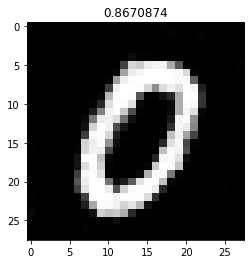

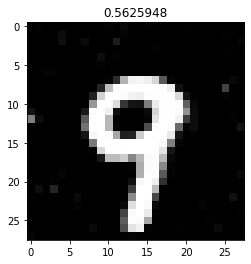

In [ ]:
with torch.no_grad():
  generator.eval()
  ExamplesNbre=20
  noise = torch.Tensor(ExamplesNbre, noise_dim).normal_(0, 1).cuda() if cuda else torch.Tensor(ExamplesNbre, noise_dim).normal_(0, 1)
  fake_imgs=generator(noise)
  preds=discriminator(fake_imgs)
  for i in range(ExamplesNbre):
    display_MNIST_image(fake_imgs[i].detach().cpu())
    plt.title(preds[i].detach().cpu().numpy()[0])

# Crating and training deep conv GAN

In [ ]:
class DCGenerator(nn.Module):
  def __init__(self):
    super(DCGenerator, self).__init__()
    self.Layer_1=nn.Sequential(nn.ConvTranspose2d(noise_dim,512,4,1,0),nn.BatchNorm2d(512),nn.ReLU())
    self.Layer_2=nn.Sequential(nn.ConvTranspose2d(512,256,4,2,1),nn.BatchNorm2d(256),nn.ReLU())
    self.Layer_3=nn.Sequential(nn.ConvTranspose2d(256,128,4,2,1),nn.BatchNorm2d(128),nn.ReLU())
    self.Final_layer=nn.Sequential(nn.ConvTranspose2d(128,1,4,2,1),nn.Tanh())
  def forward(self,x):
    out=self.Final_layer(self.Layer_3(self.Layer_2(self.Layer_1(x))))
    out=out.view(-1,1,img_dims[0],img_dims[1])
    return out

In [ ]:
class DCDiscriminator(nn.Module):
  def __init__(self):
    super(DCDiscriminator,self).__init__()
    self.Layer_1=nn.Sequential(nn.Conv2d(1,64,4,2,1),nn.LeakyReLU(0.2,inplace=True))
    self.Layer_2=nn.Sequential(nn.Conv2d(64,128,4,2,1),nn.BatchNorm2d(128),nn.LeakyReLU(0.2,inplace=True))
    self.Layer_3=nn.Sequential(nn.Conv2d(128,256,4,2,1),nn.BatchNorm2d(256),nn.LeakyReLU(0.2,inplace=True))
    self.Final_layer=nn.Sequential(nn.Conv2d(256,1,4,1,0),nn.Sigmoid())
  def forward(self,x):
    out=self.Final_layer(self.Layer_3(self.Layer_2(self.Layer_1(x))))
    out=out.view(out.shape[0],-1)
    return out

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
DCgenerator=DCGenerator()
DCdiscriminator=DCDiscriminator()
DCgenerator.apply(weights_init)
DCdiscriminator.apply(weights_init)
optimizer_DCG=optim.Adam(DCgenerator.parameters(),lr=0.0002,betas=(0.5,0.999))
optimizer_DCD=optim.Adam(DCdiscriminator.parameters(),lr=0.0002,betas=(0.5,0.999))
loss_function=nn.BCELoss()

In [ ]:
def train_DCdiscriminator(real_imgs):
  require_grad(DCgenerator,False)
  require_grad(DCdiscriminator,True)
  noise = torch.randn(real_imgs.shape[0], noise_dim,1,1).cuda() if cuda else torch.Tensor(real_imgs.shape[0], noise_dim,1,1).normal_(0, 1)
  fake_imgs = DCgenerator(noise)
  #display_MNIST_image(fake_imgs[0].detach())
  fake_preds=DCdiscriminator(fake_imgs)
  fake_gt=torch.zeros(fake_preds.shape,dtype=fake_preds.dtype).cuda() if cuda else torch.zeros(fake_preds.shape,dtype=fake_preds.dtype)
  real_preds=DCdiscriminator(real_imgs.cuda()) if cuda else DCdiscriminator(real_imgs)
  real_gt=torch.ones(real_preds.shape,dtype=real_preds.dtype).cuda() if cuda else torch.ones(real_preds.shape,dtype=real_preds.dtype)
  accuracy=( (real_preds>0.5)*1  + (fake_preds<0.5)*1 ).sum() / (real_preds.shape[0]+fake_preds.shape[0])

  optimizer_DCD.zero_grad()
  d_loss=loss_function(fake_preds,fake_gt)+loss_function(real_preds,real_gt)
  d_loss.backward()
  optimizer_DCD.step()
  return d_loss.item(),accuracy.item()

In [ ]:
def train_DCgenerator():
  require_grad(DCgenerator,True)
  require_grad(DCdiscriminator,False)
  noise = torch.randn(real_imgs.shape[0], noise_dim,1,1).cuda().cuda() if cuda else torch.Tensor(real_imgs.shape[0], noise_dim,1,1).normal_(0, 1)
  fake_imgs = DCgenerator(noise)
  #display_MNIST_image(fake_imgs[0].detach().cpu())
  fake_preds=DCdiscriminator(fake_imgs)
  fake_gt=torch.ones(fake_preds.shape,dtype=fake_preds.dtype).cuda() if cuda else torch.ones(fake_preds.shape,dtype=fake_preds.dtype)
  
  optimizer_DCG.zero_grad()
  g_loss=loss_function(fake_preds,fake_gt)
  g_loss.backward()
  optimizer_DCG.step()
  return g_loss.item()
  

In [ ]:
def require_grad(model,b):
  for p in model.parameters():
    p.requires_grad=b

In [ ]:
cuda=torch.cuda.is_available()
if cuda:
  DCgenerator=DCgenerator.cuda()
  DCdiscriminator=DCdiscriminator.cuda()
DCgenerator.train()
DCdiscriminator.train()
epochs=20
loss_per_e=[]
accuracy_per_e=[]
for e in range(epochs):
  d_losses=[]
  g_losses=[]
  accuracies=[]
  for i, (real_imgs, _) in enumerate(dataloader):
    d_loss,accuracy=train_DCdiscriminator(real_imgs)
    d_losses.append(d_loss)
    accuracies.append(accuracy)
    g_loss=train_DCgenerator()
    g_losses.append(g_loss)
  avg_acc,avg_gloss,avg_dloss=sum(accuracies)*100/len(accuracies),sum(g_losses)/len(g_losses),sum(d_losses)/len(d_losses)
  print("epoch : %3d D_accuracy = %5.2f D_loss = %5.3f G_loss = %5.3f "%(e,avg_acc,avg_dloss,avg_gloss))
  loss_per_e.append((avg_gloss,avg_dloss))
  accuracy_per_e.append(avg_acc)

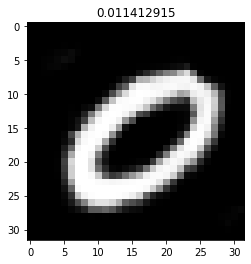

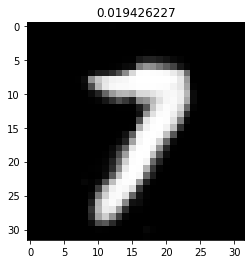

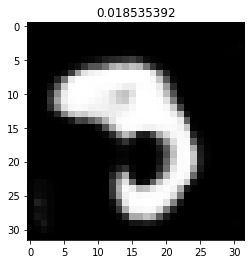

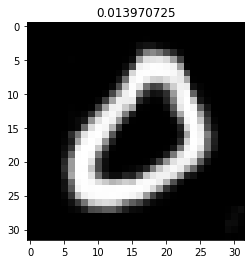

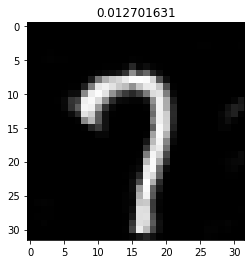

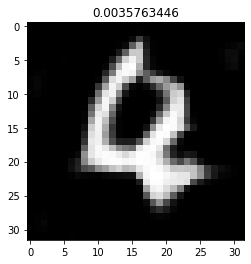

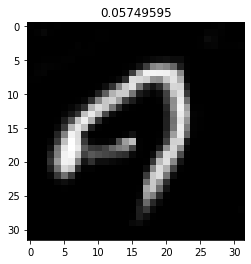

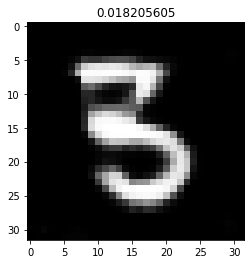

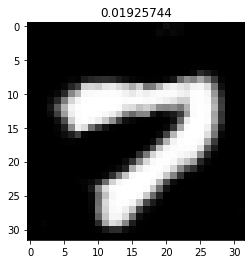

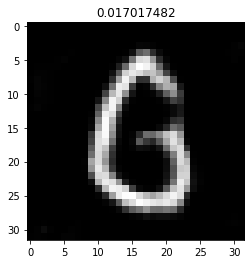

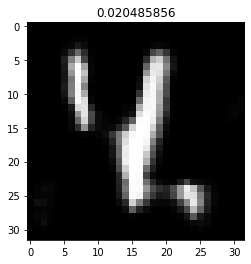

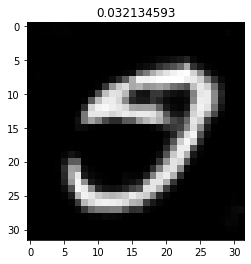

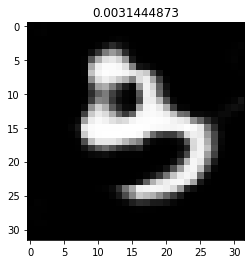

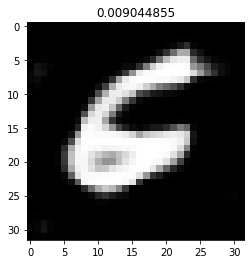

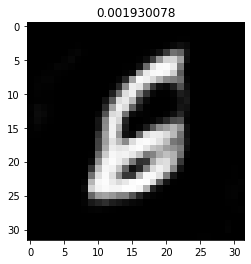

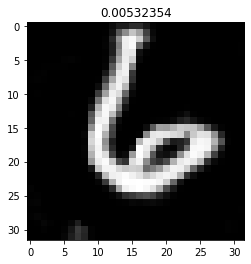

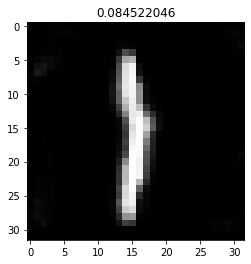

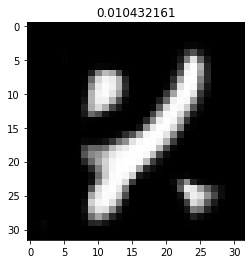

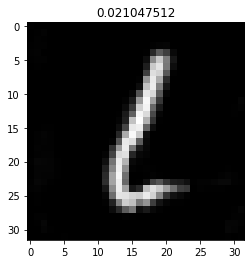

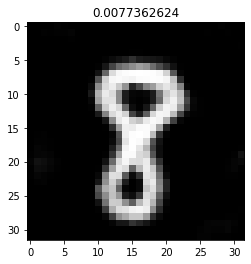

In [ ]:
with torch.no_grad():
  DCgenerator.eval()
  ExamplesNbre=20
  noise = torch.Tensor(ExamplesNbre, noise_dim,1,1).normal_(0, 1).cuda() if cuda else torch.Tensor(ExamplesNbre, noise_dim,1,1).normal_(0, 1)
  fake_imgs=DCgenerator(noise)
  preds=DCdiscriminator(fake_imgs)
  for i in range(ExamplesNbre):
    display_MNIST_image(fake_imgs[i].detach().cpu())
    plt.title(preds[i].detach().cpu().numpy()[0])